# Cox-Ingersoll-Ross (CIR) Model for Short Rate

The written report for this project can be found [here](https://brianlim.xyz/files/Portfolio/Cox-Ingersoll-Ross%20Model.pdf).

## Import Libraries

The following libraries will be needed for this notebook.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data Processing

The functions below help convert from years (`int`) to labels (`str`) and vice versa. 

- 1.0 = 1Y
- 0.5 = 6M
- 1.5 = 1Y6M

In [2]:
# Convert years to labels
def to_string(y):
    if y == 0:
        return ''
    elif y < 1:
        return f'{int(12*y)}M'
    else:
        return f'{int(y)}Y' + to_string(y%1)

# Convert labels to years
def to_year(s):
    y = 0
    if 'Y' in s:
        y += int(s[:s.find('Y')])
        s = s[s.find('Y')+1:]
    if 'M' in s:
        y += int(s[:s.find('M')]) / 12
    return y

The function below returns the number of years (30/360) from `date` to `years` years from `date`. An optional argument `years_prev` returns the number of years between `years_prev` years from `date` and `year` years from `date`.

In [3]:
# 30 / 360 day count convention
def maturity(date, years, years_prev=0):
    return years - years_prev

The function below performs bootstraping to obtain zero rates. `dt` refers to the coupon frequency and zero rate tenors are calculated.

In [4]:
# Performs bootstrapping to obtain zero rates
def bootstrap(df, dt=0.5):
    interp = {}
    discount = {}
    zero_rate = {}
    date = df['Date']

    # Input given tenors
    for t in df.index.drop('Date'):
        interp[to_year(t)] = df[t]
    
    # Max maturity
    N = max(interp.keys()) + dt

    for t in np.arange(dt,N,dt):
        # Interpolated Rates
        if t not in interp:
            for T in np.arange(t,N,dt):
                if T in interp: 
                    break
            interp[t] = np.interp(maturity(date, t), [maturity(date, t-dt), maturity(date, T)], [interp[t-dt], interp[T]])

        # Discount Factor
        if t <= 1:
            discount[t] = 1 / (1 + interp[t] / 100 * maturity(date, t))
        else:
            discount[t] = 1
            for tt in np.arange(dt,t,dt):
                discount[t] -= interp[t] / 100 * discount[tt] * maturity(date, tt, tt-dt)
            discount[t] /= (1 + interp[t] / 100 * maturity(date, t, t-dt))
            
        # Zero-Rate
        zero_rate[t] = - 100 * np.log(discount[t]) / maturity(date, t)
        
        # Modify entry
        if to_string(t) in df.index:
            df[to_string(t)] = zero_rate[t]
      
    # Convert the rest of the tenors to continuous
    for t in df.index.drop('Date'):
        if to_year(t) < dt:
            df[t] = 100 * np.log(1 + df[t] / 100 * maturity(date, to_year(t))) / maturity(date, to_year(t))

    return df

The data used is the [US Treasury Par Yield Curves](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202205). The data is first cleaned and the zero rates are obtained using bootstraping.

In [5]:
# Read csv
df = pd.read_csv('us-treasury.csv')

# Clean data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Compute continuously compounded short rate and bootstrap zero-rates
df = df.apply(lambda df: bootstrap(df), axis=1)

df

,Date,1M,2M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
0,2018-01-02,1.289307,NaN,1.437414,1.603554,1.813457,1.912380,2.002932,2.248385,2.382577,2.464703,2.665469,2.887828
1,2018-01-03,1.289307,NaN,1.407521,1.583713,1.793815,1.932639,2.012938,2.248072,2.371744,2.443189,2.644487,2.852350
2,2018-01-04,1.279318,NaN,1.407521,1.593634,1.803636,1.952577,2.042973,2.267762,2.380913,2.463490,2.641126,2.864056
3,2018-01-05,1.269328,NaN,1.387590,1.573792,1.783992,1.952796,2.053258,2.288260,2.401280,2.472826,2.662650,2.885700
4,2018-01-08,1.299296,NaN,1.447378,1.593634,1.774168,1.952832,2.063417,2.288041,2.411714,2.494059,2.671606,2.880877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2019-12-24,1.549000,1.577923,1.576888,1.603554,1.518414,1.614153,1.634113,1.715415,1.829148,1.901559,2.237957,2.392743
495,2019-12-26,1.588948,1.597870,1.576888,1.603554,1.518414,1.634184,1.643988,1.715101,1.849795,1.900640,2.225777,2.394414
496,2019-12-27,1.558987,1.557976,1.566927,1.583713,1.498713,1.584290,1.594188,1.675544,1.799663,1.882627,2.218281,2.386100
497,2019-12-30,1.509051,1.528053,1.566927,1.593634,1.557803,1.573845,1.583915,1.675599,1.810144,1.903685,2.250902,2.405079


Afterwards, the data from January 2018 to March 2019 are selected. January 2018 to December 2018 is the in-sample data and January 2019 to March 2019 is the out-of-sample data. Additional regression variables are also calculated. These are explained below.

In [6]:
# Filter data from January 2018 to March 2019
df = df[(df['Date'] >= dt.datetime(2018,1,1)) & (df['Date'] < dt.datetime(2019,4,1))].reset_index(drop=True)

# Add regression columns
lag = 1
df['r'] = df['3M'] / 100
df['r_prev'] = df['r'].shift(lag)
df['dt'] = 1 / 260
df['x1'] = df['dt'] / np.sqrt(np.abs(df['r_prev']))
df['x2'] = - np.sqrt(np.abs(df['r_prev'])) * df['dt']
df['y'] = (df['r'] - df['r_prev']) / np.sqrt(np.abs(df['r_prev']))
df = df[df['y'].notna()].reset_index(drop=True)

df

,Date,1M,2M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y,r,r_prev,dt,x1,x2,y
0,2018-01-03,1.289307,NaN,1.407521,1.583713,1.793815,1.932639,2.012938,2.248072,2.371744,2.443189,2.644487,2.852350,0.014075,0.014374,0.003846,0.032080,-0.000461,-0.002493
1,2018-01-04,1.279318,NaN,1.407521,1.593634,1.803636,1.952577,2.042973,2.267762,2.380913,2.463490,2.641126,2.864056,0.014075,0.014075,0.003846,0.032419,-0.000456,0.000000
2,2018-01-05,1.269328,NaN,1.387590,1.573792,1.783992,1.952796,2.053258,2.288260,2.401280,2.472826,2.662650,2.885700,0.013876,0.014075,0.003846,0.032419,-0.000456,-0.001680
3,2018-01-08,1.299296,NaN,1.447378,1.593634,1.774168,1.952832,2.063417,2.288041,2.411714,2.494059,2.671606,2.880877,0.014474,0.013876,0.003846,0.032651,-0.000453,0.005076
4,2018-01-09,1.269328,NaN,1.437414,1.593634,1.764344,1.972970,2.083467,2.328703,2.462823,2.555798,2.744791,2.954877,0.014374,0.014474,0.003846,0.031969,-0.000463,-0.000828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2019-03-25,2.467461,2.464930,2.452466,2.474627,2.381418,2.245285,2.175181,2.196841,2.312692,2.430147,2.715895,2.965666,0.024525,0.024525,0.003846,0.024560,-0.000602,0.000000
305,2019-03-26,2.457482,2.435052,2.452466,2.474627,2.410708,2.224986,2.165180,2.166390,2.282355,2.410750,2.707931,2.956942,0.024525,0.024525,0.003846,0.024560,-0.000602,0.000000
306,2019-03-27,2.447502,2.425092,2.432588,2.444994,2.371653,2.205447,2.145563,2.167192,2.272437,2.389921,2.663359,2.926763,0.024326,0.024525,0.003846,0.024560,-0.000602,-0.001269
307,2019-03-28,2.437523,2.445011,2.422649,2.425236,2.371653,2.215507,2.165666,2.187175,2.281891,2.388657,2.650751,2.900026,0.024226,0.024326,0.003846,0.024660,-0.000600,-0.000637


## Parameter Estimation

Following [Miao (2018)](http://urn.kb.se/resolve?urn=urn:nbn:se:lnu:diva-79154), in estimating the parameters $a$, $b$, and $\sigma$, the discrete version of the CIR model is considered. Suppose $t_i$ is the $i$ th trading day of the period $[0,T]$. Then, the short rate follows the process
\begin{align*}
    \Delta r_t &= a^* \left(b^*-r_t\right) \Delta t + \sigma \sqrt{|r_t|} \Delta W_t \\
    r_{t+1} - r_t &= a^* \left(b^*-r_t\right) \Delta t + \sigma \sqrt{|r_t|} \sqrt{\Delta t}~ \varepsilon \\
    \dfrac{r_{t+1} - r_t}{\sqrt{|r_t|}} &= \dfrac{a^* \left(b^*-r_t\right) \Delta t}{\sqrt{|r_t|}} + \sigma \sqrt{\Delta t}~ \varepsilon \\
    &= a^*b^* \dfrac{\Delta t}{\sqrt{|r_t|}} - a^* \sqrt{|r_t|} \Delta t + \sigma \sqrt{\Delta t}~ \varepsilon \\
    &= \beta_1 x_1 + \beta_2 x_2 + \epsilon,
\end{align*}
where $\varepsilon \sim N(0,1)$, $\beta_1 = a^* b^*$, $\beta_2 = a^*$, $x_1 = \dfrac{\Delta t}{\sqrt{|r_t|}}$, and $x_2 = - \sqrt{|r_t|} \Delta t$. In this form, it is apparent that the coefficients $a$, $b$, $\sigma$ can be obtained using linear regression, where $\sigma = \dfrac{\text{std error}}{\sqrt{\Delta t}}$. 

The cell below estimates the parameters $a$, $b$, and $\sigma$.

In [7]:
# Create in sample data frame
reg_df = df.copy()
reg_df = reg_df[reg_df['Date'] < dt.datetime(2019,1,1)].reset_index(drop=True)

# Perform linear regression
model = sm.OLS(endog=reg_df['y'], exog=reg_df[['x1', 'x2']]).fit()

# Get coeffcients
ab = model.params['x1']
a = model.params['x2']
b = ab / a
sigma = np.sqrt(model.scale) / np.sqrt(reg_df['dt'].mean())
gamma = np.sqrt(a**2 + 2*sigma**2)

print(f'a\t {a}')
print(f'b\t {b}')
print(f'gamma\t {gamma}')
print(f'sigma\t {sigma}')

a	 0.9190434577374313
b	 0.03111387947048586
gamma	 0.9196108792715653
sigma	 0.02283957163179303


## Forecasting Short Rates & Term Structure

After obtaining the parameter values, the short rate can then be forecasted also using the discretized CIR model. Given $r_t$, the short rate tomorrow $r_{t+1}$ is obtained as
$$r_{t+1} = r_t + a^* \left(b^*-r_t\right) \Delta t + \sigma \sqrt{|r_t|} \sqrt{\Delta t}~ \varepsilon,$$
where $\varepsilon \sim N(0,1)$ is a randomly generated number from the standard normal distribution. 

The yield curve can then be obtained as 
\begin{align*}
    R(t,T) &= -\frac{1}{T-t} \ln P(t,T) \\
    &= -\frac{1}{T-t} \ln A(t,T) + \frac{1}{T-t} B(t,T) r_t,
\end{align*}
with 
$$B(t,T) = \frac{2\left(e^{\gamma(T-t)}-1\right)}{\left(\gamma +a)(e^{\gamma(T-t)}-1\right) + 2\gamma},$$
$$A(t,T) = \left[\frac{2\gamma e^{(a+\gamma)(T-t)/2}}{(\gamma +a)\left(e^{\gamma(T-t)} -1\right) + 2\gamma} \right]^{2ab/\sigma^2},$$
where $\gamma = \sqrt{a^2+2\sigma^2}$.

The cell below performs `N` simulations of the short rate and the yield curve and its average is obtained.

In [8]:
# Simulate N times
N = 1000
# Tenors to forecast
tenors = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
# New dataframe
pred_df = df.copy()

for s in range(N):
    # For each date i
    for i in pred_df.index:
        if s == 0:
            pred_df.loc[i, 'r_pred'] = 0
            for t in tenors:
                pred_df.loc[i, to_string(t)] = 0

        # If in-sample, skip
        if pred_df.loc[i,'Date'] < dt.datetime(2019,1,1):
            continue
        
        # Get previous r and forecast using discrete CIR
        r = pred_df.loc[i-lag, 'r']
        pred_df.loc[i, 'r'] = r + a * (b - r) * pred_df.loc[i, 'dt'] + sigma * np.sqrt(np.abs(r) * pred_df.loc[i, 'dt']) * np.random.randn()
        pred_df.loc[i, 'r_pred'] += 100 * pred_df.loc[i, 'r'] / N

        # Forecast yield curve
        for t in tenors:
            Bt = (2*(np.exp(gamma*t) - 1)) / ((gamma + a) * (np.exp(gamma*t) - 1) + 2*gamma) 
            At = ( (2*gamma * np.exp((a+gamma)*t/2)) / ((gamma+a) * (np.exp(gamma*t)-1) + 2*gamma) ) ** (2*a*b/sigma**2)
            Rt = - 1/t * np.log(At) + 1/t * Bt * pred_df.loc[i, 'r']
            pred_df.loc[i, to_string(t)] += 100 * Rt / N
            
pred_df = pred_df[pred_df['Date'] >= dt.datetime(2019,1,1)]

pred_df

,Date,1M,2M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y,r,r_prev,dt,x1,x2,y,r_pred
248,2019-01-02,2.470276,2.493906,2.516372,2.577415,2.675689,2.806429,2.884740,2.967314,3.007329,3.038150,3.074285,3.086333,0.024141,0.024425,0.003846,0.024610,-0.000601,-0.001908,2.445414
249,2019-01-03,2.472455,2.496004,2.518394,2.579229,2.677169,2.807464,2.885509,2.967801,3.007680,3.038396,3.074408,3.086415,0.024168,0.024127,0.003846,0.024761,-0.000597,-0.000640,2.447677
250,2019-01-04,2.475279,2.498724,2.521015,2.581581,2.679087,2.808806,2.886505,2.968433,3.008135,3.038715,3.074568,3.086521,0.024065,0.024028,0.003846,0.024813,-0.000596,0.000641,2.450611
251,2019-01-07,2.478496,2.501823,2.524001,2.584260,2.681273,2.810334,2.887640,2.969152,3.008654,3.039079,3.074750,3.086642,0.024603,0.024127,0.003846,0.024761,-0.000597,0.001920,2.453953
252,2019-01-08,2.480349,2.503608,2.525721,2.585803,2.682532,2.811215,2.888294,2.969567,3.008952,3.039288,3.074854,3.086712,0.024640,0.024425,0.003846,0.024610,-0.000601,0.000636,2.455878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2019-03-25,2.586576,2.605918,2.624307,2.674270,2.754700,2.861688,2.925768,2.993331,3.026072,3.051290,3.080856,3.090713,0.023382,0.024525,0.003846,0.024560,-0.000602,0.000000,2.566224
305,2019-03-26,2.587423,2.606734,2.625094,2.674976,2.755276,2.862091,2.926067,2.993521,3.026208,3.051386,3.080904,3.090745,0.022934,0.024525,0.003846,0.024560,-0.000602,0.000000,2.567104
306,2019-03-27,2.590011,2.609226,2.627495,2.677131,2.757034,2.863320,2.926979,2.994099,3.026626,3.051678,3.081050,3.090843,0.023007,0.024525,0.003846,0.024560,-0.000602,-0.001269,2.569792
307,2019-03-28,2.591700,2.610854,2.629063,2.678538,2.758181,2.864123,2.927575,2.994477,3.026898,3.051869,3.081145,3.090906,0.023153,0.024326,0.003846,0.024660,-0.000600,-0.000637,2.571547


The functions below plot the yield curve (surface and cross section).

In [9]:
# Function to map values
def zero_rate(X,Y,df):
    Z = np.zeros(X.shape)
    for x in range(X.shape[0]):
        for y in range(X.shape[1]):
            Z[x][y] = df[df['Date'] == Y[x][y]][to_string(X[x][y])].iloc[0]
    return Z

# Function to plot surface
def plot_surf(df, tenors):
    # Meshgrid
    x = tenors
    y = df['Date']
    X, Y = np.meshgrid(x, y)
    Z = zero_rate(X,Y,df)

    # Change axes
    y = (df['Date'] - min(df['Date'])).dt.days
    X, Y = np.meshgrid(x, y)

    # Plot surface
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Date')
    fig.show()

# Plot a cross section of yield curve
def cross(pred_df, df, date):
    pred_df = pred_df[pred_df['Date'] == date][['Date'] + [to_string(t) for t in tenors]].set_index('Date')
    df = df[df['Date'] == date][['Date'] + [to_string(t) for t in tenors]].set_index('Date')
    
    pred_df.columns = [to_year(col) for col in pred_df.columns]
    pred_df.index = ['Predicted']
    df.columns = [to_year(col) for col in df.columns]
    df.index = ['Actual']

    cross_df = pd.merge(pred_df.T, df.T, how='outer', left_index=True, right_index=True)
    plt.plot(cross_df)
    plt.xlabel('Maturity')
    plt.ylabel('Zero-Rate')
    plt.legend(('Predicted', 'Actual'))

Afterwards, the forecasted yield curve, actual yield curve, and in-sample yield curve are plotted below. 

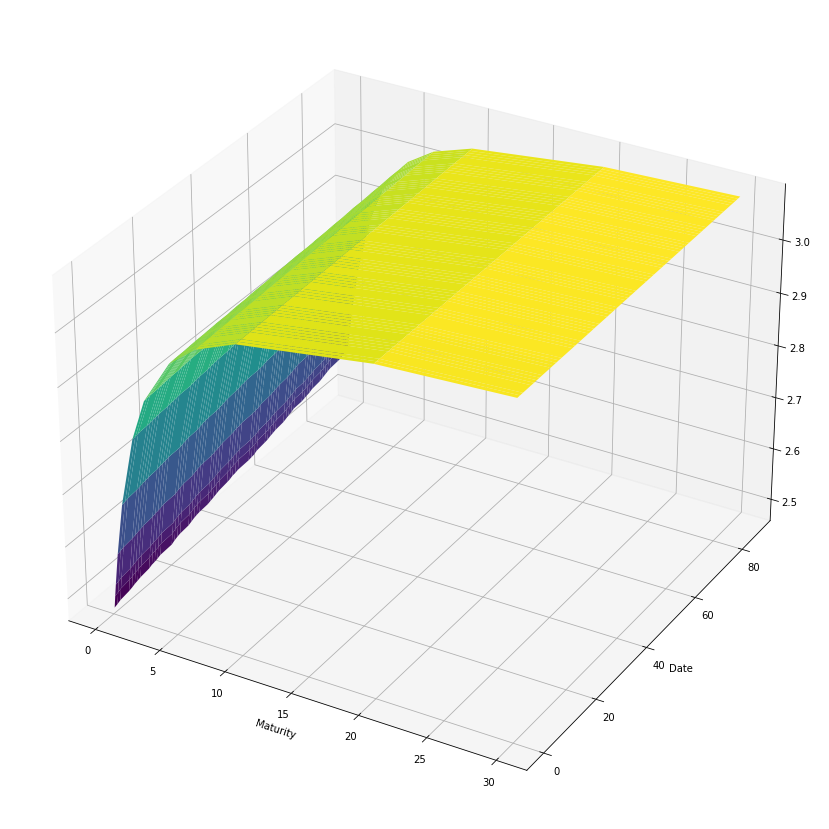

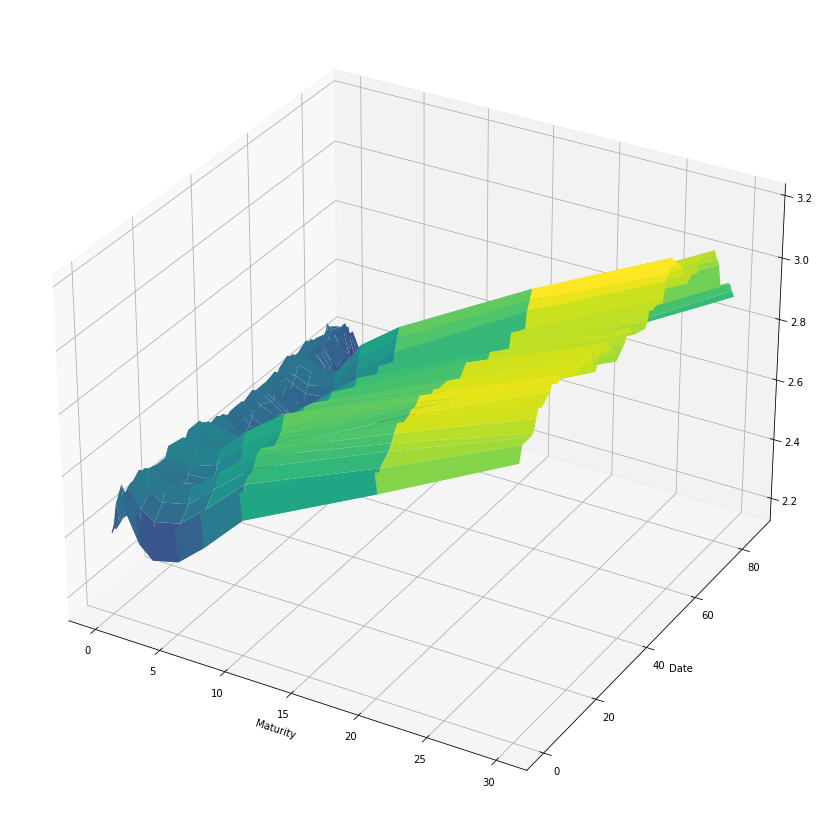

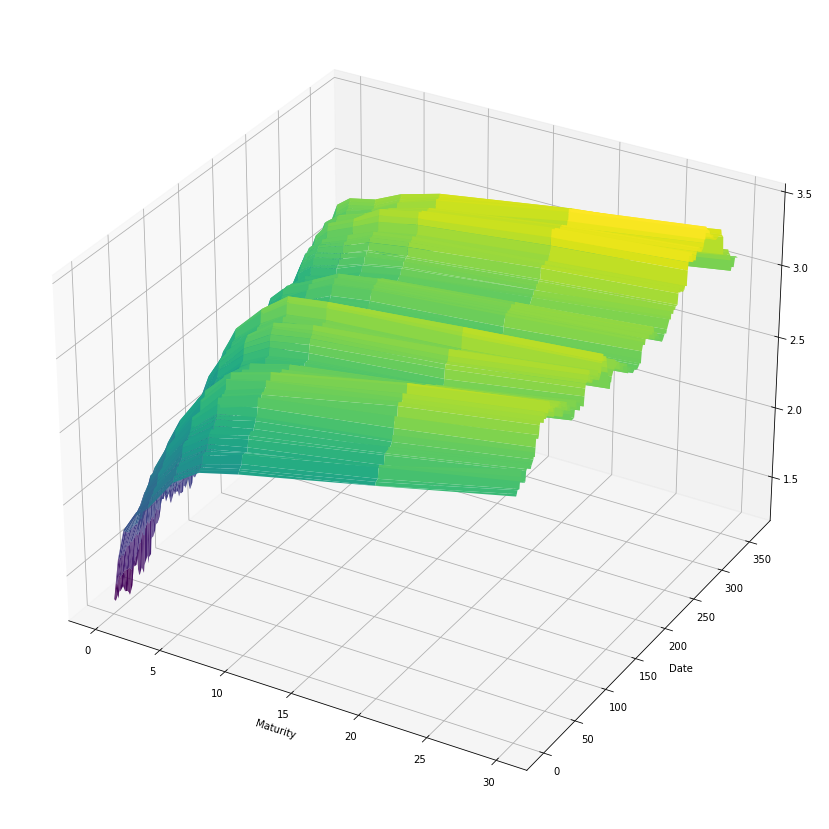

In [10]:
tenors = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
# Forecasted yield curve
plot_surf(pred_df[pred_df['Date'] >= dt.datetime(2019,1,1)], tenors)
# Actual yield curve
plot_surf(df[df['Date'] >= dt.datetime(2019,1,1)], tenors)

tenors = [1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30] # NAN's error for 2/12
# In-sample yield curve
plot_surf(df[df['Date'] < dt.datetime(2019,1,1)], tenors)

A cross section of the yield curve at March 29, 2019 is also plotted below.

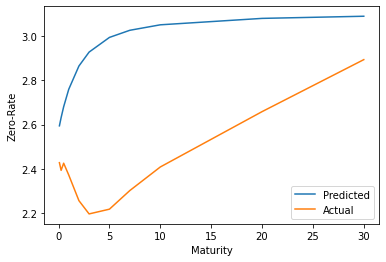

In [11]:
cross(pred_df, df, dt.datetime(2019,3,29))

The function below plots the short rate time series.

In [12]:
# Plot a time series of short rates
def short(pred_df, df):
    pred_df = pred_df[['Date', 'r']].rename({'r': 'Predicted'}, axis=1)
    df = df[['Date', 'r']].rename({'r': 'Actual'}, axis=1)
    
    short_df = pd.merge(pred_df, df, how='inner', on='Date').set_index('Date')
    short_df['Predicted'] *= 100
    short_df['Actual'] *= 100
    plt.plot(short_df)
    plt.xlabel('Date')
    plt.ylabel('Short Rate')
    plt.xticks(rotation = 30)
    plt.legend(('Predicted', 'Actual'))

Finally, the short rates are plotted below.

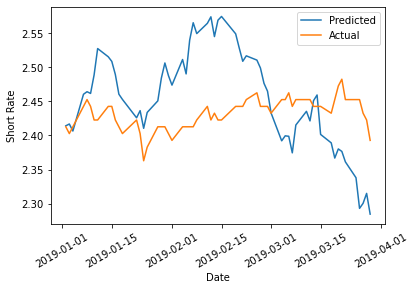

In [13]:
short(pred_df, df)